In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import scipy.sparse as sparse

In [ ]:
'''Exact diagonalization of the Lindbladian spin model in the sector of highest total spin'''

#generate spin matrices for spin S
def get_spin(S):
    Nj = int((2*S)+1)
    Sp = sparse.csr_matrix(np.zeros((Nj,Nj), dtype = float))
    Sm = sparse.csr_matrix(np.zeros((Nj,Nj), dtype = float))
    Sz = sparse.csr_matrix(np.zeros((Nj,Nj), dtype = float))
    I = sparse.csr_matrix(np.eye(Nj, dtype = float))
    for i in range(Nj):
        Sz[i,i]=S-i
    for i in range(Nj-1):
        m=S-i-1
        Sp[i,i+1]=np.sqrt(S*(S+1)-m*(m+1))
    for i in range(Nj-1):
        m=S-i
        Sm[i+1,i]=np.sqrt(S*(S+1)-m*(m-1))
    return Sz,Sp,Sm,I

#effective Hamiltonian in the sector of hiighest total spin
def get_H(L,p,J):
    Sz,Sp,Sm,I= get_spin(L/2)
    Sx=(Sp+Sm)/2
    return 2*J*(L**2*I-4*Sx@Sx)-p/2*(Sp@Sp+L*Sz-Sz@Sz-L**2/4*I)-p*L/4*I+p/2*Sz

#effective Hamiltonian on the reduced Hilbert space \widetilde{H}
def get_L_red(L,p,J):
    X,Y,Z = generate_paulis(L)
    Sp=[]
    H=0
    I=sparse.csr_matrix(np.eye(2**L, dtype = float))
    for i in range(L):
        Sp.append(1/2*(X[i]+1j*Y[i]))
    for i in range(L):
        for j in range(L):
            if not(i==j):
                H+=-p*(2*Sp[i]@Sp[j]-(I-Z[i])@(I-Z[j])/4)+2*J*(I-X[i]@X[j])
    return H
    
pauli_x = sparse.csr_matrix(np.array([[0,1],[1,0]]))
pauli_y = sparse.csr_matrix(np.array([[0,-1j],[1j,0]]))
pauli_z = sparse.csr_matrix(np.array([[1,0],[0,-1]]))
I = sparse.csr_matrix(np.eye(2))

    
def generate_op_at_site(L,site,operator):
    op = I
    for i in range(L):
        if i==site:
            current_op=operator
        else:
            current_op=I
        op = sparse.kron(op,current_op, format = "csr") if i!= 0 else current_op
    return op

def generate_paulis(L):
    X=[]
    Y=[]
    Z=[]
    for i in range(L): 
        X.append(generate_op_at_site(L,i,pauli_x))
        Y.append(generate_op_at_site(L,i,pauli_y))
        Z.append(generate_op_at_site(L,i,pauli_z))
    return X,Y,Z


In [ ]:
'''
Since the effective Hamiltonian is non hermitian and potentially non-diagonalizable,
 we compute the time evolution directly to find the steady state value of the Rényi.2 correlator
 '''

ps = np.linspace(0,80,30)
Ls = [8,16,32,64,128]

cors = np.zeros((len(Ls),len(ps)))
for i,L in enumerate(Ls):
    print(L)
    Sz,Sp,Sm,I=get_spin(L/2)
    X=Sp+Sm
    all_up=np.zeros(L+1)
    all_up[0]=1
    for j,p in enumerate(ps):
        print(p)
        H=get_H(L,p,1)
        v=all_up.copy()
        Nt=40
        Tmax=1
        for t in np.linspace(0,Tmax,Nt):
            v=sparse.linalg.expm_multiply(-Tmax/Nt*H,v)
            v=v/np.linalg.norm(v)
        cors[i,j]=v.transpose().conj()@X@X@v/L**2
print(cors)

8
0.0
2.7586206896551726
5.517241379310345
8.275862068965518
11.03448275862069
13.793103448275863
16.551724137931036
19.310344827586206
22.06896551724138
24.827586206896555
27.586206896551726
30.344827586206897
33.10344827586207
35.862068965517246
38.62068965517241
41.37931034482759
44.13793103448276
46.896551724137936
49.65517241379311
52.41379310344828
55.17241379310345
57.931034482758626
60.689655172413794
63.44827586206897
66.20689655172414
68.96551724137932
71.72413793103449
74.48275862068967
77.24137931034483
80.0
16
0.0
2.7586206896551726
5.517241379310345
8.275862068965518
11.03448275862069
13.793103448275863
16.551724137931036
19.310344827586206
22.06896551724138
24.827586206896555
27.586206896551726
30.344827586206897
33.10344827586207
35.862068965517246
38.62068965517241
41.37931034482759
44.13793103448276
46.896551724137936
49.65517241379311
52.41379310344828
55.17241379310345
57.931034482758626
60.689655172413794
63.44827586206897
66.20689655172414
68.96551724137932
71.724

In [ ]:
file_name="..\\data\\Lindbladian_data\\Lindbladian_Renyi_2.csv"
    
data = {
"L8": np.array(cors[0,:]),
"L16": np.array(cors[1,:]),
"L32": np.array(cors[2,:]),
"L64": np.array(cors[3,:]),
"L128": np.array(cors[4,:]),
"p": ps,
}

df = pd.DataFrame(data)

df.to_csv(file_name, mode='a', index=False, header=True)

## Fig 6

In [3]:
Renyi2_cors = pd.read_csv("..\\data\\Lindbladian_data\\Lindbladian_Renyi_2.csv")

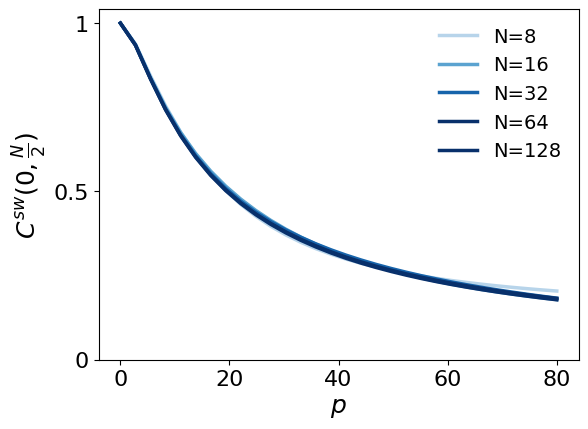

In [ ]:
fig, ax = plt.subplots(1)
colors = plt.get_cmap("Blues")(np.linspace(0.3, 1.3, 5))
ax.plot(ps, Renyi2_cors["L8"], color=colors[0], label = "N=8", linewidth=2.5)
ax.plot(ps, Renyi2_cors["L16"], color=colors[1], label = "N=16", linewidth=2.5)
ax.plot(ps, Renyi2_cors["L32"], color=colors[2], label = "N=32", linewidth=2.5)
ax.plot(ps, Renyi2_cors["L64"], color=colors[3], label = "N=64", linewidth=2.5)
ax.plot(ps, Renyi2_cors["L128"], color=colors[4], label = "N=128", linewidth=2.5)
ax.legend(fontsize = 14, frameon = False)
ax.set_xlabel(r"$p$", fontsize = 18)

ax.set_yticks([0,0.5,1])
ax.set_xticks([0,20,40,60,80])
ax.set_yticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 16)

plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.15)


ax.set_ylabel(r"$C^{sw}(0,\frac{N}{2})$", fontsize = 18)


In [ ]:
'''compute the fidelity correlator for the Lindbladian model'''
N=20
Ls=np.array([4,8,12])
ps = np.linspace(0,80,N)
fid_cor=np.zeros((4,N))
trace_var = np.zeros((4,N))
trace = np.zeros((4,N))
for i,L in enumerate(Ls):
    print(L)
    X,Y,Z = generate_paulis(L)
    for j,p in enumerate(ps):   
        print(p)
        H=get_L_red(L,p,1)
        all_up=np.zeros(2**L)
        all_up[0]=1
        state=all_up.copy()
        Nt =10
        Tmax = 2
        for t in np.linspace(0,Tmax,Nt):
            state=sparse.linalg.expm_multiply(-Tmax/Nt*H,state)
            state=state/np.linalg.norm(state)
        trace_var[i,j]=2**(L-1)-np.sum(np.abs(state))
        trace[i,j]=np.sum(np.abs(state))
        sqrt_state = np.sqrt(np.abs(state[:]))
        density = sc.sparse.diags(np.abs(state[:]),0)
        density_trans = (X[0]@X[int(L/2)]@density@X[int(L/2)]@X[0])
        sigma_rho = (density@density_trans).diagonal()
        fid=(np.sqrt(sigma_rho)).sum()/trace[i,j]
        fid_cor[i,j]=fid
    print()

16
0.0


KeyboardInterrupt: 

In [23]:
file_name="..\\data\\Lindbladian_data\\Lindbladian_Fidelity.csv"
    
data = {
"L4": np.array(fid_cor[0,:]),
"L8": np.array(fid_cor[1,:]),
"L16": np.array(fid_cor[2,:]),
"p": ps,
}

df = pd.DataFrame(data)

df.to_csv(file_name, mode='a', index=False, header=True)

## Fig. 7(c)

In [ ]:
fidelity_exact = pd.read_csv("..\\data\\Lindbladian_data\\Lindbladian_Fidelity.csv")

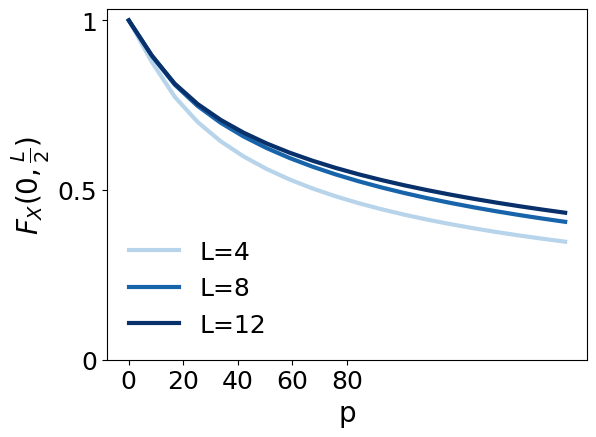

In [ ]:
fig, ax = plt.subplots(1)
colors = plt.get_cmap("Blues")(np.linspace(0.3, 1.3, 3))
ax.plot(2*ps,fidelity_exact["L4"], color = colors[0], label = "L=4", linewidth = 3)
ax.plot(2*ps,fidelity_exact["L8"], color = colors[1], label = "L=8", linewidth = 3)
ax.plot(2*ps,fidelity_exact["L16"], color = colors[2], label = "L=12", linewidth = 3)
ax.legend(fontsize = 18, frameon = False, loc = "lower left")

ax.set_yticks([0,0.5,1])
ax.set_xticks([0,20,40,60,80])
ax.set_yticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 18)

ax.set_ylabel(r"$F_X(0,\frac{L}{2})$", fontsize = 20)

ax.set_xlabel(r"p", fontsize = 20)

plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.15)

